In [1]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn

from drdmannturb.enums import DataType
from drdmannturb.parameters import (
    LossParameters,
    NNParameters,
    PhysicalParameters,
    ProblemParameters,
)
from drdmannturb.spectra_fitting import CalibrationProblem, OnePointSpectraDataGenerator


In [2]:
device = "cpu"

In [3]:
domain = torch.logspace(-1, 3, 40)
domain

tensor([1.0000e-01, 1.2664e-01, 1.6037e-01, 2.0309e-01, 2.5719e-01, 3.2570e-01,
        4.1246e-01, 5.2233e-01, 6.6147e-01, 8.3768e-01, 1.0608e+00, 1.3434e+00,
        1.7013e+00, 2.1544e+00, 2.7283e+00, 3.4551e+00, 4.3755e+00, 5.5410e+00,
        7.0170e+00, 8.8862e+00, 1.1253e+01, 1.4251e+01, 1.8047e+01, 2.2855e+01,
        2.8943e+01, 3.6652e+01, 4.6416e+01, 5.8780e+01, 7.4438e+01, 9.4267e+01,
        1.1938e+02, 1.5118e+02, 1.9145e+02, 2.4245e+02, 3.0703e+02, 3.8882e+02,
        4.9239e+02, 6.2355e+02, 7.8965e+02, 1.0000e+03])

In [4]:
L = 70
Gamma = 3.7
sigma = 0.04
Uref = 21
zref = 1


pb = CalibrationProblem(
    nn_params=NNParameters(
        nlayers=2, hidden_layer_sizes=[10, 10], activations=[nn.ReLU(), nn.ReLU()]
    ),
    prob_params=ProblemParameters(
        data_type=DataType.CUSTOM, tol=1e-9, nepochs=5, learn_nu=True
    ),
    loss_params=LossParameters(alpha_pen2=1.0, beta_reg=1e-5),
    phys_params=PhysicalParameters(
        L=L,
        Gamma=Gamma,
        sigma=sigma,
        domain=domain,
        Uref=Uref,
        zref=zref,
    ),
    logging_directory="runs/custom_data",
    device=device,
)

In [5]:
spectra_file = Path("data_cleaned/cleaned_weighted_spectra_quarter.dat")
CustomData = torch.tensor(np.genfromtxt(spectra_file, skip_header=1, delimiter = ","))

In [6]:
CustomData.shape

torch.Size([423, 5])

In [7]:
# Take 1/4 of the data, evenly spaced over the range
# CustomData_quarter = CustomData[::4, :]

In [8]:

f = CustomData[:, 0]
k1_data_pts = 2 * torch.pi * f / Uref

gen = OnePointSpectraDataGenerator(
    zref = zref,
    data_points = k1_data_pts,
    data_type = DataType.CUSTOM,
    spectra_file = spectra_file,
    k1_data_points = k1_data_pts.data.cpu().numpy(),
)


Data = gen.Data

In [9]:
gen.plot()

In [10]:
optimal_parameters = pb.calibrate(data=Data)

Initial loss: 81.56273245693092


100%|██████████| 5/5 [14:11<00:00, 170.38s/it]


Spectra fitting concluded with final loss: 0.9039787805956776
Learned nu value: Parameter containing:
tensor(0.4280, dtype=torch.float64, requires_grad=True)


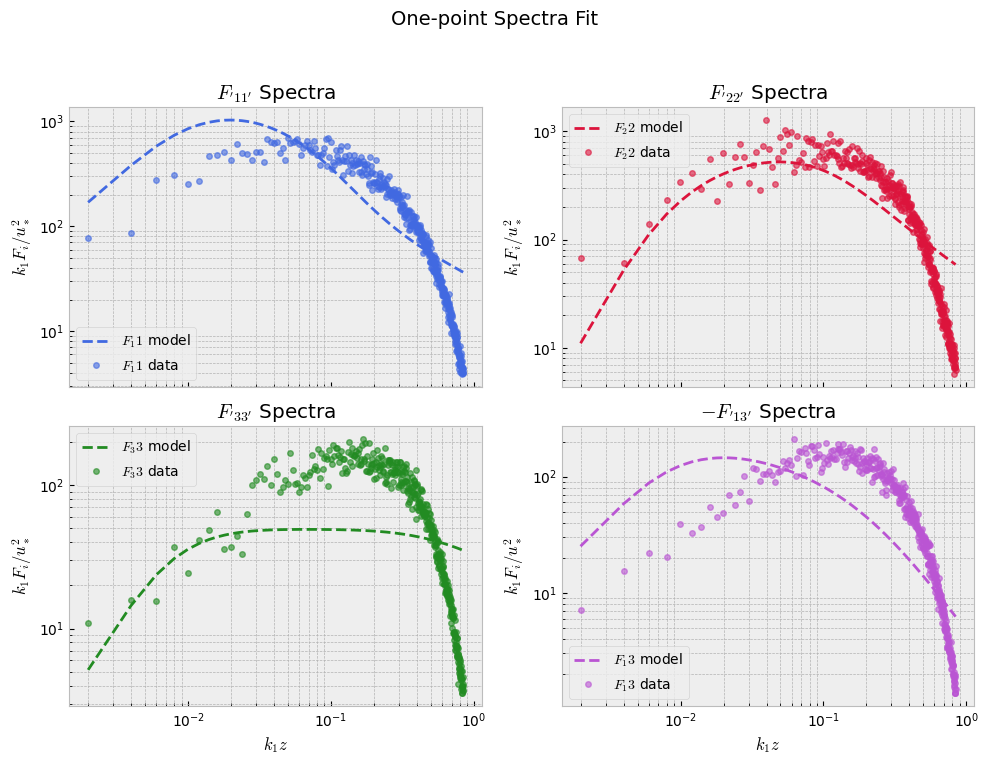

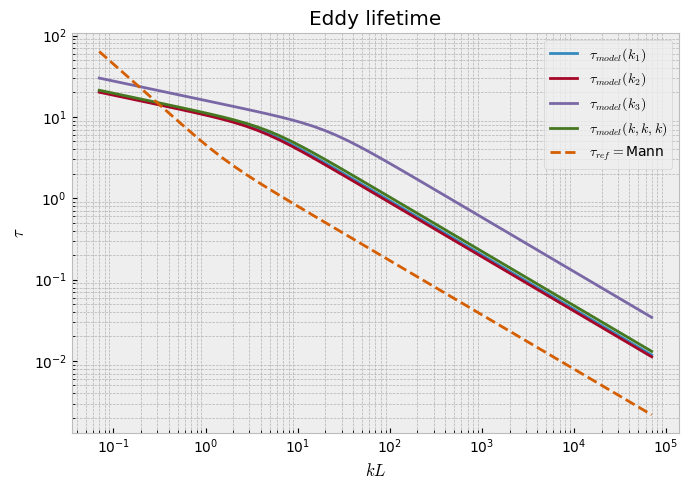

In [11]:
pb.plot()